# Kaggle設置

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# read env var
!pip install python-dotenv
import dotenv
import os

dotenv.load_dotenv("/content/drive/MyDrive/中興_人工智慧概論/HW_final/.env")
api_token = {"username":os.getenv("KAGGLE_USERNAME"),"key":os.getenv("KAGGLE_KEY")}

!pip install kaggle

import json

kaggle_path = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_path, exist_ok=True)

with open(os.path.join(kaggle_path, "kaggle.json"), "w") as f:
    json.dump(api_token, f)

os.chmod(os.path.join(kaggle_path, "kaggle.json"), 0o600)

In [3]:
api_token["username"]

'johnnydo0730'

# 下載資料

In [5]:
#FER 2013
!kaggle datasets download msambare/fer2013
!unzip /content/fer2013.zip -d /content/fer2013

#FER plus
!kaggle datasets download subhaditya/fer2013plus
!unzip /content/fer2013plus.zip -d /content/ferplus

# RAF-DB
!kaggle datasets download shuvoalok/raf-db-dataset
!unzip /content/raf-db-dataset.zip -d /content/RAF-DB

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/RAF-DB/DATASET/train/5/train_00987_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_00990_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_00991_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_00992_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_01002_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_01010_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_01011_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_01013_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_01015_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_01017_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_01039_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_01048_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_01049_aligned.jpg  
  inflating: /content/RAF-DB/DATASET/train/5/train_01053

# Test

## init

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_vgg
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
import pickle
import tensorflow as tf
import cv2
import os

In [7]:
from keras.models import load_model
import os

root_dir = '/content/drive/MyDrive/中興_人工智慧概論/HW_final'
save_dir = '/content/drive/MyDrive/中興_人工智慧概論/HW_final/test'

models_info = {
    "VGG19": {
        "fine_tune_phase": 3,
        "preprocess_input": preprocess_input_vgg
    },
    "ResNet50": {
        "fine_tune_phase": 3,
        "preprocess_input": preprocess_input_resnet
    },
    "EfficientNetB0": {
        "fine_tune_phase": 3,
        "preprocess_input": preprocess_input_efficientnet
    }
}

datasets_info = {
    "FER2013": {
        "test_dir": "/content/fer2013/test",
        "num_classes": 7
    },
    "FERplus": {
        "test_dir": "/content/ferplus/fer2013plus/fer2013/test",
        "num_classes": 8
    },
    "RAF-DB": {
        "test_dir": "/content/RAF-DB/DATASET/test",
        "num_classes": 7
    }
}

task_info = {
    "VGG19": {
        "FER2013": {"model_name": "phase3_best_model.keras"},
        "FERplus": {"model_name": "phase3_best_model.keras"},
        "RAF-DB": {"model_name": "phase3_best_model.keras"}
    },
    "ResNet50": {
        "FER2013": {"model_name": "ResNet50_FER2013_phase3.keras"},
        "FERplus": {"model_name": "ResNet50_FERplus_phase3.keras"},
        "RAF-DB": {"model_name": "ResNet50_RAF-DB_phase3.keras"}
    },
    "EfficientNetB0": {
        "FER2013": {"model_name": "EfficientNetB0_FER2013_phase3.keras"},
        "FERplus": {"model_name": "EfficientNetB0_FERplus_phase3.keras"},
        "RAF-DB": {"model_name": "EfficientNetB0_RAF-DB_phase3.keras"}
    }
}

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 合併三個 history（多階段訓練）
def merge_histories(*histories):
    merged = {}
    for h in histories:
        for key, value in h.items():
            merged.setdefault(key, []).extend(value)
    return merged

#
def get_testloader(test_dir, preprocess_input, img_size=(224, 224), batch_size=32):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        color_mode='rgb',  # 統一使用 rgb
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return test_generator

def load_task_usages(task_info, models_info, datasets_info):
    for model_name, model_info in models_info.items():
        for dataset_name, dataset_info in datasets_info.items():
            # 載入模型
            task_dir = os.path.join(root_dir, model_name, dataset_name)
            model_path = os.path.join(task_dir, task_info[model_name][dataset_name]["model_name"])
            model = load_model(model_path, compile=False)
            model.trainable = False
            for layer in model.layers:
                layer.trainable = False
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            task_info[model_name][dataset_name]["model"] = model

            # 載入dataloader
            task_info[model_name][dataset_name]["test_generator"] = get_testloader(
                dataset_info["test_dir"],
                model_info["preprocess_input"])

            # 讀取各階段 history 並合併
            histories = []
            for phase in range(1, model_info["fine_tune_phase"] + 1):
                history_path = os.path.join(task_dir, f"phase{phase}_history.pkl")
                with open(history_path, 'rb') as f:
                    history = pickle.load(f)
                histories.append(history)
            task_info[model_name][dataset_name]["history"] = merge_histories(*histories)

    return task_info

Found 7178 images belonging to 7 classes.
Found 7099 images belonging to 8 classes.
Found 3068 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 7099 images belonging to 8 classes.
Found 3068 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 7099 images belonging to 8 classes.
Found 3068 images belonging to 7 classes.


In [ ]:
task_info = load_task_usages(task_info, models_info, datasets_info)

In [11]:
# test acc, loss
import pandas as pd

# 儲存結果的列表
results = []

# 計算 test acc 並儲存
for model_name, model_info in models_info.items():
    for dataset_name, dataset_info in datasets_info.items():
        # 取得模型與測試資料
        model = task_info[model_name][dataset_name]["model"]
        test_generator = task_info[model_name][dataset_name]["test_generator"]

        # 計算測試準確率
        loss, acc = model.evaluate(test_generator, verbose=0)

        # 加入結果
        results.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "Test Accuracy": round(acc, 4),
            "Test Loss": round(loss, 4)
        })

        task_info[model_name][dataset_name]['test_acc'] = acc
        task_info[model_name][dataset_name]['test_loss'] = loss
        print(f"Test Accuracy for {model_name} on {dataset_name}: {acc}")

# 建立 DataFrame 並顯示
df = pd.DataFrame(results)
print(df)

# 存成 CSV
#df.to_csv(os.path.join(save_dir, "test_results.csv"), index=False)


Test Accuracy for VGG19 on FER2013: 0.6297018527984619
Test Accuracy for VGG19 on FERplus: 0.807155966758728
Test Accuracy for VGG19 on RAF-DB: 0.7835723757743835
Test Accuracy for ResNet50 on FER2013: 0.6264976263046265


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy for ResNet50 on FERplus: 0.7885617613792419
Test Accuracy for ResNet50 on RAF-DB: 0.754889190196991
Test Accuracy for EfficientNetB0 on FER2013: 0.5943159461021423
Test Accuracy for EfficientNetB0 on FERplus: 0.7488378882408142
Test Accuracy for EfficientNetB0 on RAF-DB: 0.7565189003944397
            Model  Dataset  Test Accuracy  Test Loss
0           VGG19  FER2013         0.6297     1.0110
1           VGG19  FERplus         0.8072     0.5939
2           VGG19   RAF-DB         0.7836     0.6448
3        ResNet50  FER2013         0.6265     1.0355
4        ResNet50  FERplus         0.7886     0.6330
5        ResNet50   RAF-DB         0.7549     0.7944
6  EfficientNetB0  FER2013         0.5943     1.0804
7  EfficientNetB0  FERplus         0.7488     0.7013
8  EfficientNetB0   RAF-DB         0.7565     0.6692


In [13]:
# test y_pred, y_true
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import os

# 用於按順序排入 3x3
model_list = list(models_info.keys())
dataset_list = list(datasets_info.keys())

for i, model_name in enumerate(model_list):
    for j, dataset_name in enumerate(dataset_list):
        model = task_info[model_name][dataset_name]["model"]
        test_gen = task_info[model_name][dataset_name]["test_generator"]

        # 預測與真實值
        y_true = test_gen.classes
        y_pred_probs = model.predict(test_gen, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)

        task_info[model_name][dataset_name]["y_true"] = y_true
        task_info[model_name][dataset_name]["y_pred"] = y_pred

        # check acc
        print(f"Test Accuracy for {model_name} on {dataset_name}: {np.mean(y_true == y_pred)}")

Test Accuracy for VGG19 on FER2013: 0.6297018668152689
Test Accuracy for VGG19 on FERplus: 0.8071559374559797
Test Accuracy for VGG19 on RAF-DB: 0.7835723598435462
Test Accuracy for ResNet50 on FER2013: 0.6264976316522708
Test Accuracy for ResNet50 on FERplus: 0.7885617692632765
Test Accuracy for ResNet50 on RAF-DB: 0.7548891786179922
Test Accuracy for EfficientNetB0 on FER2013: 0.5943159654499861
Test Accuracy for EfficientNetB0 on FERplus: 0.7488378644879561
Test Accuracy for EfficientNetB0 on RAF-DB: 0.7565189048239895


## train,val acc curve(done)

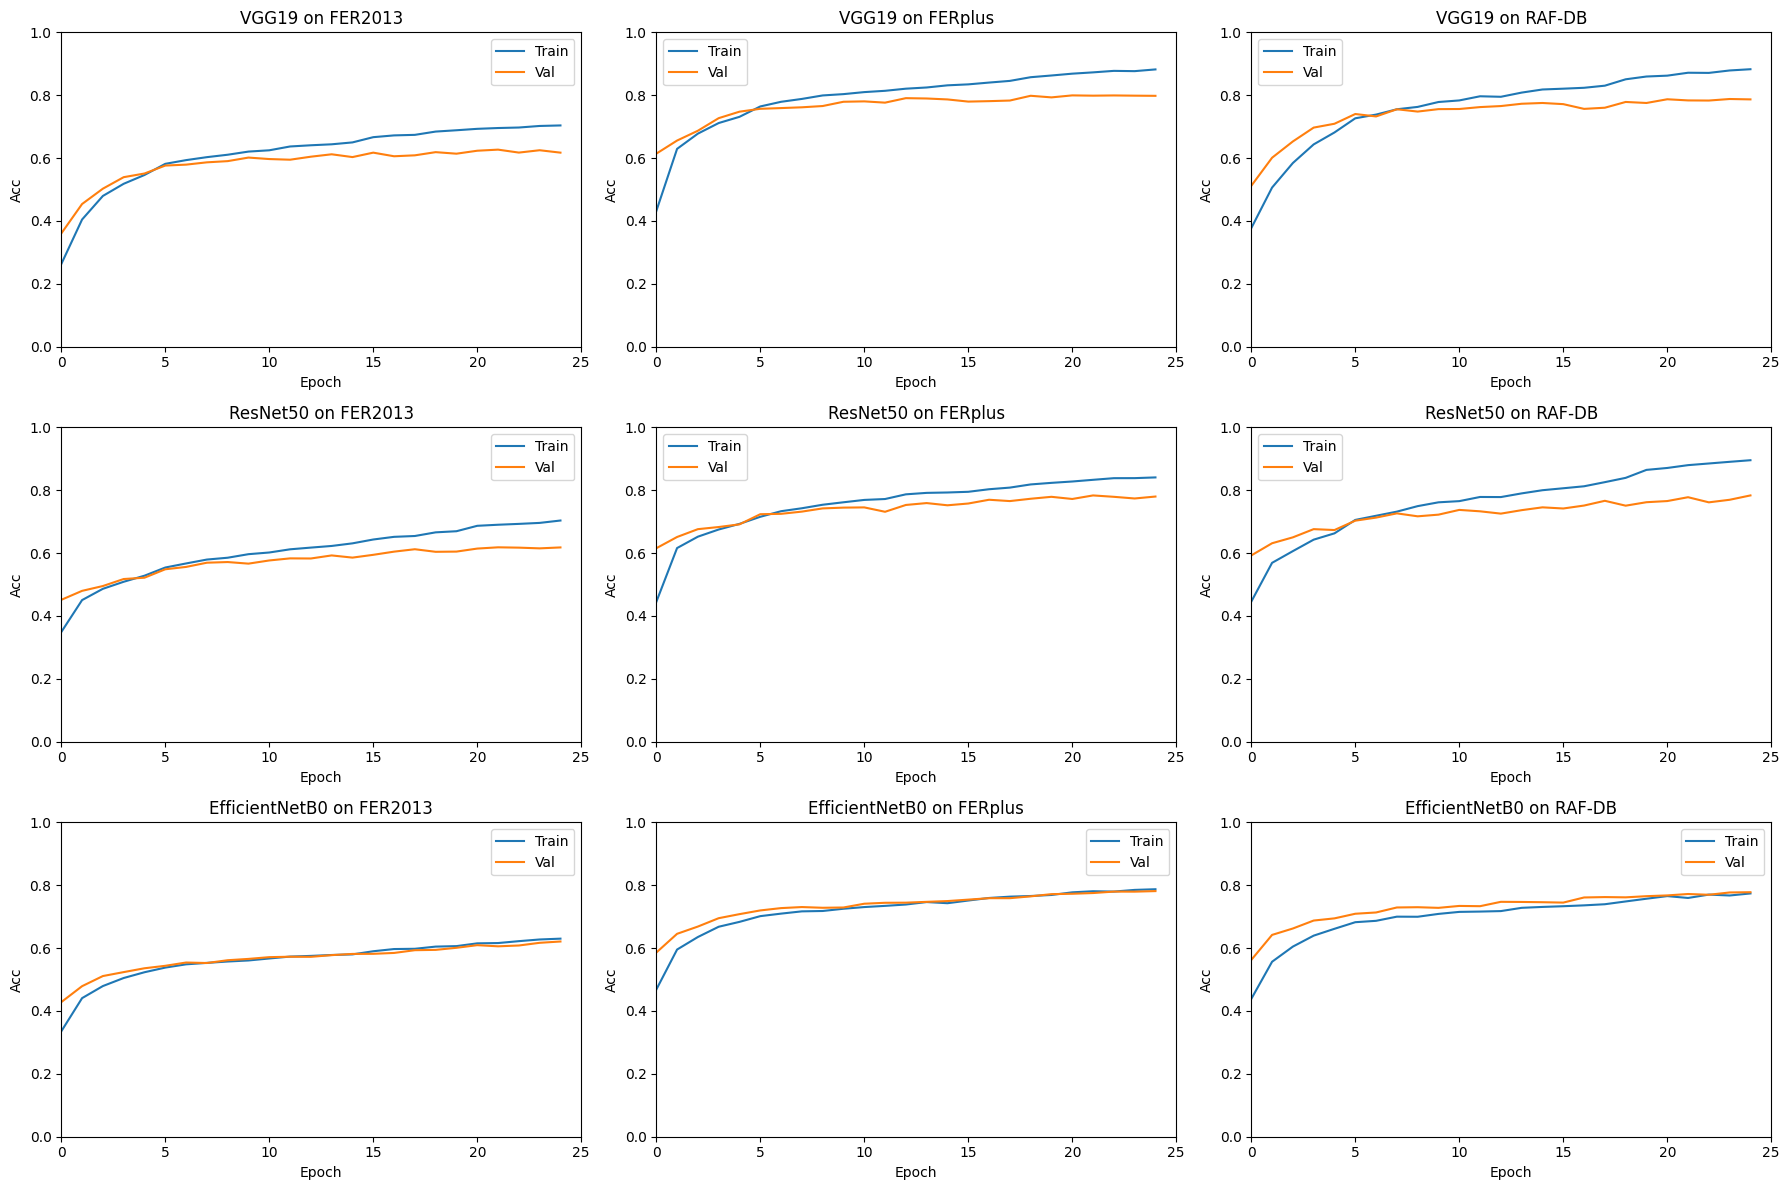

In [30]:
import matplotlib.pyplot as plt
import pickle
import os

# 設定畫面
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

i = 0  # subplot 編號
for model_name, model_info in models_info.items():
    for dataset_name, dataset_info in datasets_info.items():

        full_history = task_info[model_name][dataset_name]["history"]

        # 畫子圖
        ax = axes[i]
        ax.plot(full_history['accuracy'], label='Train')
        ax.plot(full_history['val_accuracy'], label='Val')
        ax.set_title(f'{model_name} on {dataset_name}')
        ax.set_ylim(0, 1)
        ax.set_xlim(0, 25)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Acc')
        ax.legend()
        i += 1

# 若總組合少於 9，隱藏多餘子圖
for j in range(i, 9):
    axes[j].axis('off')

# 排版與儲存
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "all_accuracy_comparison.png"))
plt.show()

## train,val loss curve(done)

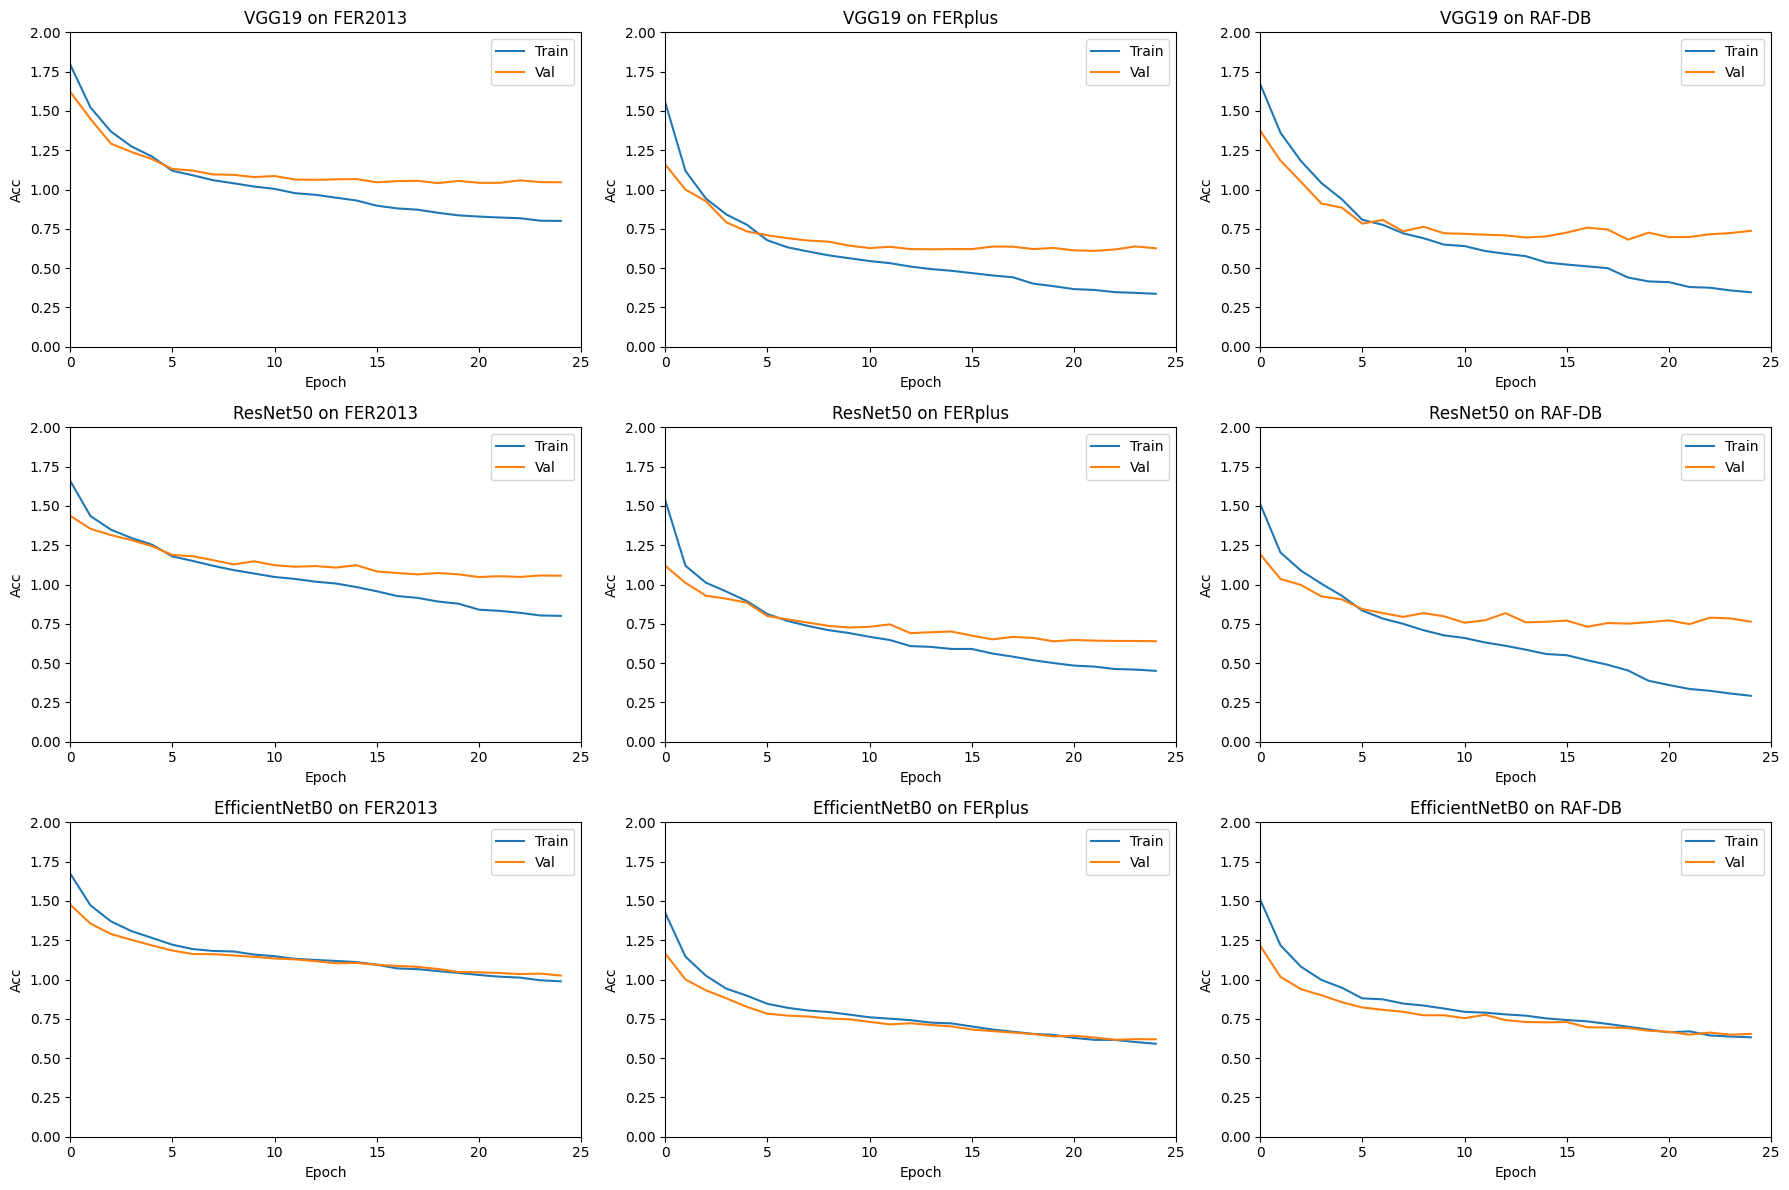

In [31]:
import matplotlib.pyplot as plt
import pickle
import os

# 合併三個 history（多階段訓練）
def merge_histories(*histories):
    merged = {}
    for h in histories:
        for key, value in h.items():
            merged.setdefault(key, []).extend(value)
    return merged

# 設定畫面
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

i = 0  # subplot 編號
for model_name, model_info in models_info.items():
    for dataset_name, dataset_info in datasets_info.items():
        full_history = task_info[model_name][dataset_name]["history"]

        # 畫子圖
        ax = axes[i]
        ax.plot(full_history['loss'], label='Train')
        ax.plot(full_history['val_loss'], label='Val')
        ax.set_title(f'{model_name} on {dataset_name}')
        ax.set_ylim(0, 2)
        ax.set_xlim(0, 25)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Acc')
        ax.legend()
        i += 1

# 若總組合少於 9，隱藏多餘子圖
for j in range(i, 9):
    axes[j].axis('off')

# 排版與儲存
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "all_loss_comparison.png"))
plt.show()

## cm(done)

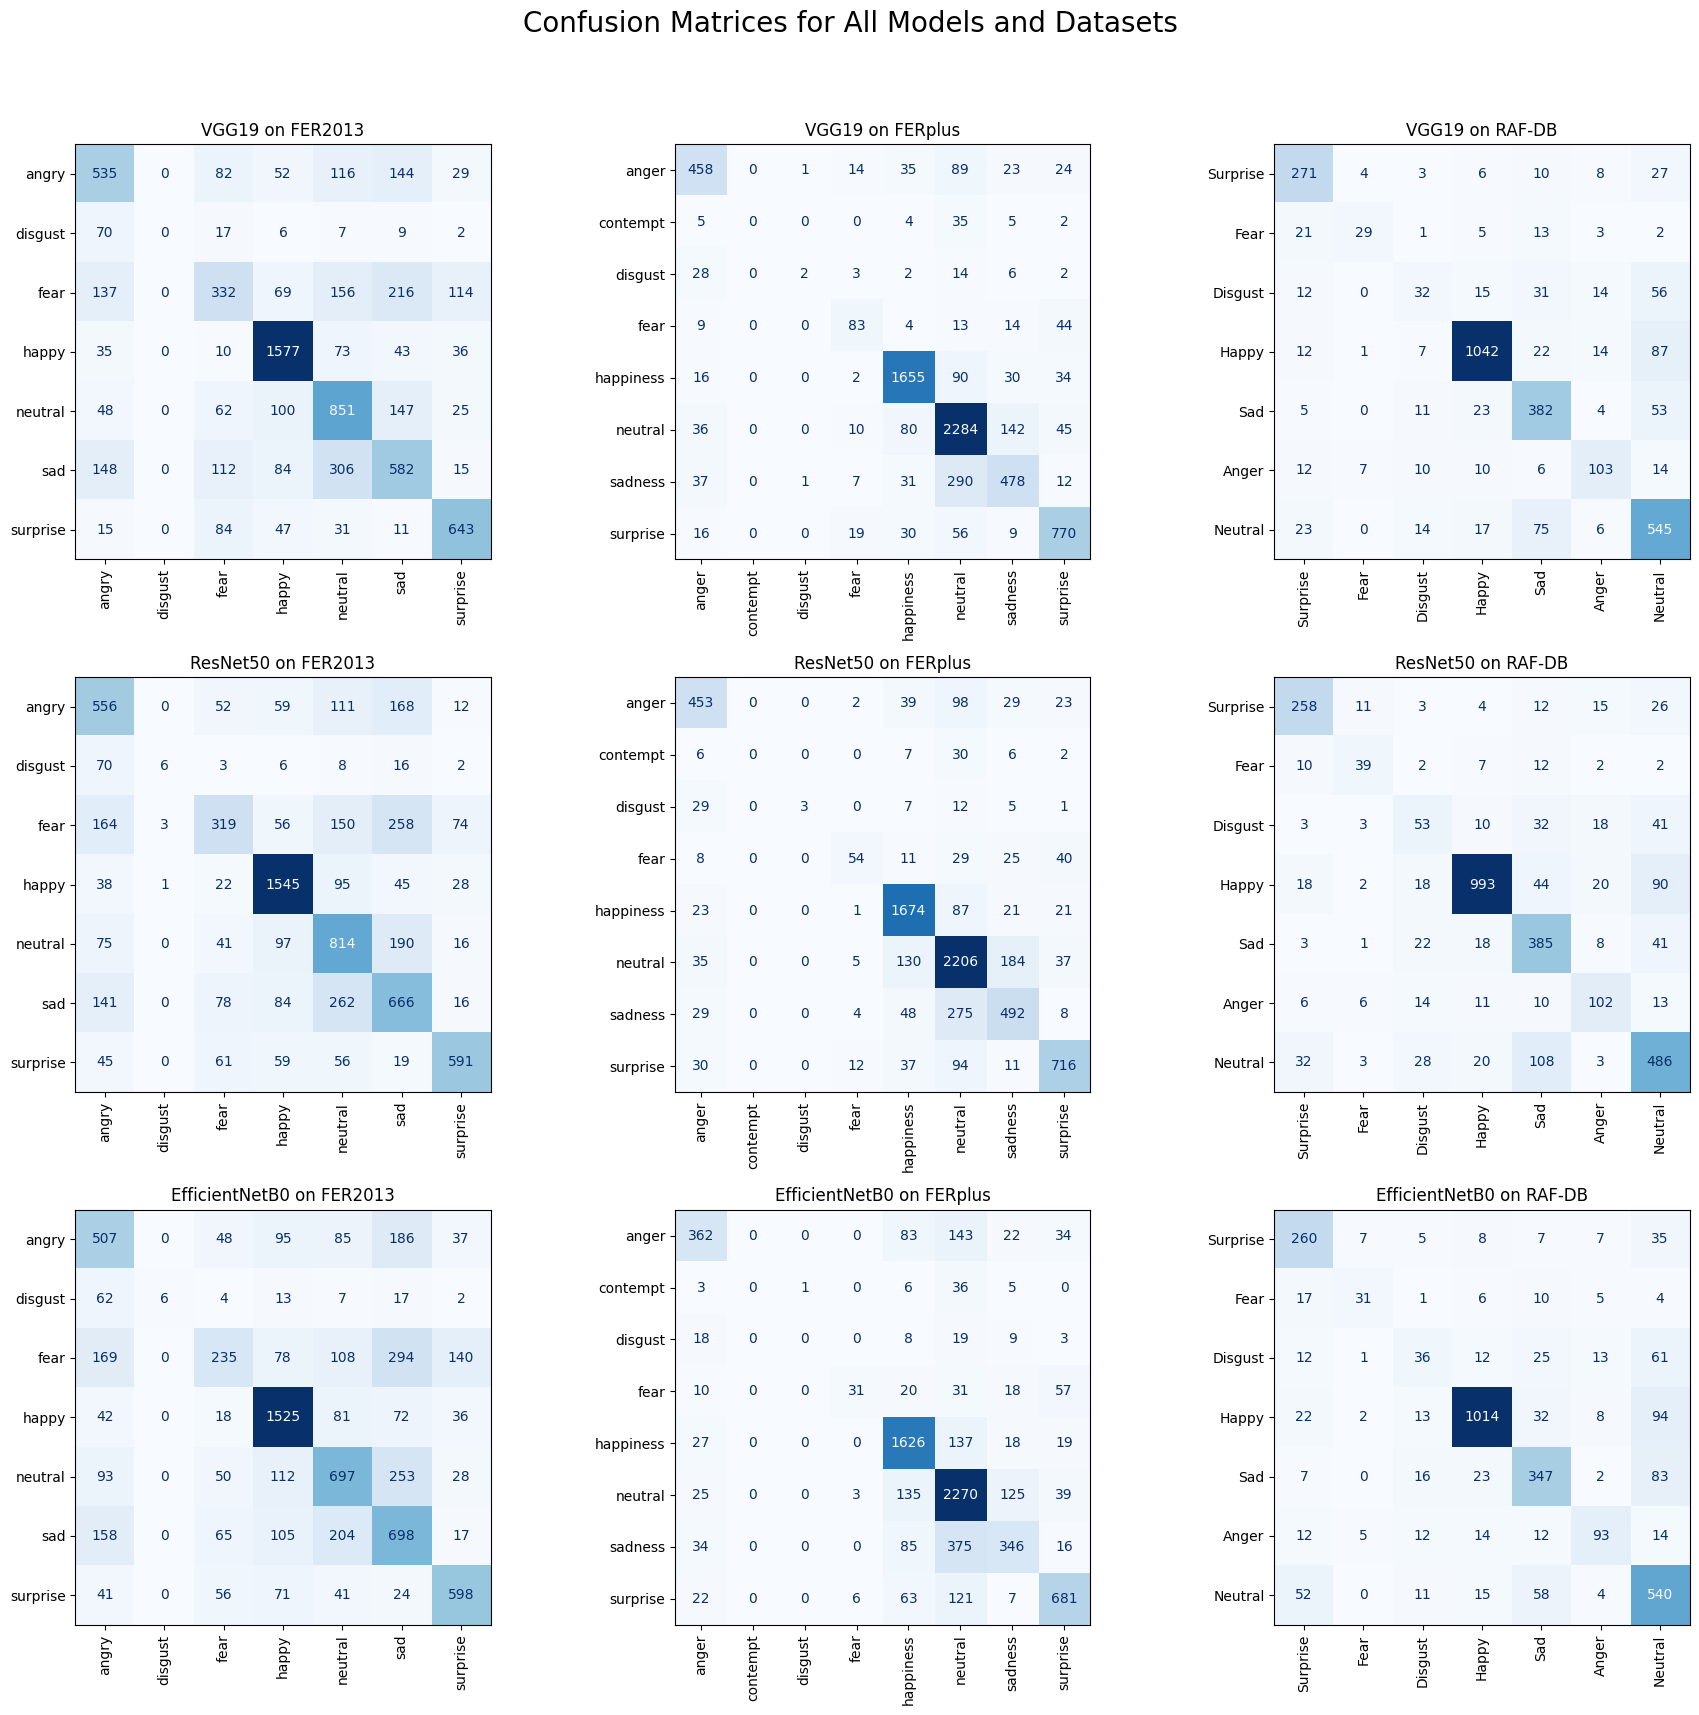

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import os

fig, axs = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle("Confusion Matrices for All Models and Datasets", fontsize=20)

# 用於按順序排入 3x3
model_list = list(models_info.keys())
dataset_list = list(datasets_info.keys())

for i, model_name in enumerate(model_list):
    for j, dataset_name in enumerate(dataset_list):

        y_true = task_info[model_name][dataset_name]["y_true"]
        y_pred = task_info[model_name][dataset_name]["y_pred"]
        test_gen = task_info[model_name][dataset_name]["test_generator"]

        # 混淆矩陣
        cm = confusion_matrix(y_true, y_pred)
        if dataset_name == 'RAF-DB':
            class_labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Anger', 'Neutral']
        else:
            class_labels = list(test_gen.class_indices.keys())

        ax = axs[i, j]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        disp.plot(ax=ax, colorbar=False, cmap='Blues', xticks_rotation='vertical')
        ax.set_title(f'{model_name} on {dataset_name}')
        ax.set_xlabel('')
        ax.set_ylabel('')

# 統一調整 layout 並儲存
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(save_dir, "all_confusion_matrices.png"))
plt.show()


## 3 score (macro weight) (done)

In [22]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# 建立儲存欄位
records = []

# 用於按順序排入 3x3
model_list = list(models_info.keys())
dataset_list = list(datasets_info.keys())

for i, model_name in enumerate(model_list):
    for j, dataset_name in enumerate(dataset_list):
        y_true = task_info[model_name][dataset_name]["y_true"]
        y_pred = task_info[model_name][dataset_name]["y_pred"]

        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0
        )
        precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', zero_division=0
        )

        records.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "Precision Macro": round(precision_macro, 4),
            "Precision Weighted": round(precision_weighted, 4),
            "Recall Macro": round(recall_macro, 4),
            "Recall Weighted": round(recall_weighted, 4),
            "F1 Macro": round(f1_macro, 4),
            "F1 Weighted": round(f1_weighted, 4),
        })

# 建立 DataFrame 並儲存為 CSV
df = pd.DataFrame.from_records(records)
df.to_csv(os.path.join(save_dir, "eval_metrics.csv"), index=False)

print(df.head())

      Model  Dataset  Precision Macro  Precision Weighted  Recall Macro  \
0     VGG19  FER2013           0.5191              0.6103        0.5289   
1     VGG19  FERplus           0.6318              0.7954        0.5553   
2     VGG19   RAF-DB           0.6989              0.7804        0.6473   
3  ResNet50  FER2013           0.6154              0.6278        0.5318   
4  ResNet50  FERplus           0.6936              0.7808        0.5269   

   Recall Weighted  F1 Macro  F1 Weighted  
0           0.6297    0.5205       0.6161  
1           0.8072    0.5666       0.7980  
2           0.7836    0.6602       0.7773  
3           0.6265    0.5344       0.6168  
4           0.7886    0.5479       0.7786  


## acc (done)

In [23]:
import pandas as pd

# 初始化結果列表
acc_results = []

# 組合資料
for model_name in task_info:
    for dataset_name in task_info[model_name]:
        task = task_info[model_name][dataset_name]
        # 取最後一個 epoch 的訓練與驗證準確率
        history = task["history"]
        train_acc = history["accuracy"][-1] if "accuracy" in history else None
        val_acc = history["val_accuracy"][-1] if "val_accuracy" in history else None
        test_acc = task.get("test_acc", None)

        acc_results.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "Train Accuracy": train_acc,
            "Validation Accuracy": val_acc,
            "Test Accuracy": test_acc
        })

# 建立 DataFrame 並儲存為 CSV
acc_df = pd.DataFrame(acc_results)
acc_df.to_csv(os.path.join(save_dir, "acc_results.csv"), index=False)

# 顯示前幾筆資料確認
print(acc_df.head())

      Model  Dataset  Train Accuracy  Validation Accuracy  Test Accuracy
0     VGG19  FER2013        0.703849             0.617314       0.629702
1     VGG19  FERplus        0.882045             0.798026       0.807156
2     VGG19   RAF-DB        0.882676             0.786705       0.783572
3  ResNet50  FER2013        0.703588             0.618011       0.626498
4  ResNet50  FERplus        0.840701             0.779873       0.788562


## grad cam

In [25]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.1 MB/s eta 0:00:00


In [61]:
def visualize_same_image_across_models(task_info, class_names, cam_layer_name, dataset_name, sample_index=0):
    import matplotlib.pyplot as plt
    from tf_keras_vis.gradcam import Gradcam
    from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
    from tf_keras_vis.utils.scores import CategoricalScore

    # 取得 sample 圖片與標籤
    sample_img = None
    sample_label = None
    for model_name in task_info:
        test_gen = task_info[model_name][dataset_name]['test_generator']
        test_gen.reset()
        img_batch, label_batch = test_gen[sample_index]
        sample_img = img_batch[0:1]
        sample_label = np.argmax(label_batch[0])
        break  # 只需一次

    # 還原圖片（左側用原圖）
    restored_img = deprocess_image(sample_img[0])

    # 準備畫圖，總欄位數 = 原圖 + 模型數
    num_models = len(task_info)
    plt.figure(figsize=(4 * (num_models + 1), 5))

    # 左側放原圖
    plt.subplot(1, num_models + 1, 1)
    plt.imshow(restored_img)
    plt.title(f"Original\nGT: {class_names[sample_label]}")
    plt.axis('off')

    # 每個模型一張 Grad-CAM
    for idx, model_name in enumerate(task_info):
        model = task_info[model_name][dataset_name]['model']
        layer_name = cam_layer_name[model_name]

        # Grad-CAM 初始化
        gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)

        # 模型預測
        pred = model.predict(sample_img, verbose=0)
        pred_class = np.argmax(pred[0])
        is_correct = (pred_class == sample_label)

        # Grad-CAM 熱區圖
        score = CategoricalScore([pred_class])
        cam = gradcam(score, sample_img, penultimate_layer=layer_name)
        heatmap = cam[0]

        # 顯示 Grad-CAM 疊圖
        plt.subplot(1, num_models + 1, idx + 2)
        plt.imshow(restored_img)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.title(f"{model_name}\nPred: {class_names[pred_class]}")
        plt.axis('off')

    plt.suptitle(f"Grad-CAM Comparison on {dataset_name} (Sample #{sample_index*32})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 預留上方空間給 suptitle
    # save
    plt.savefig(os.path.join(save_dir, f"gradcam_comparison_{dataset_name}_sample_{sample_index*32}.png"))
    plt.show()

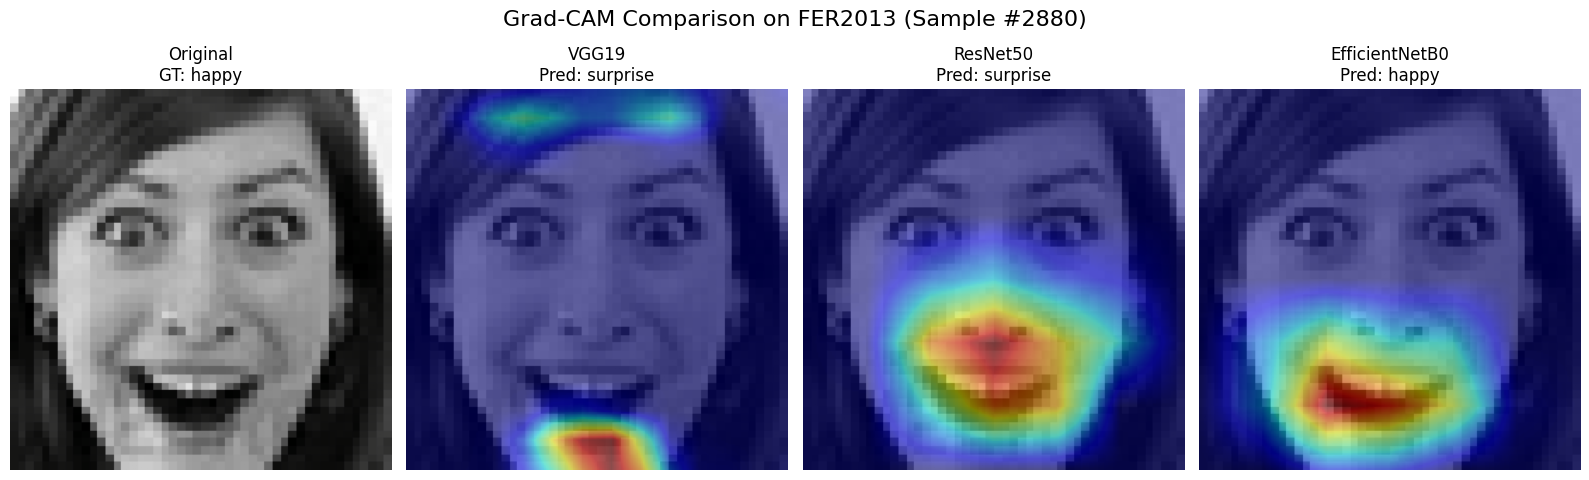

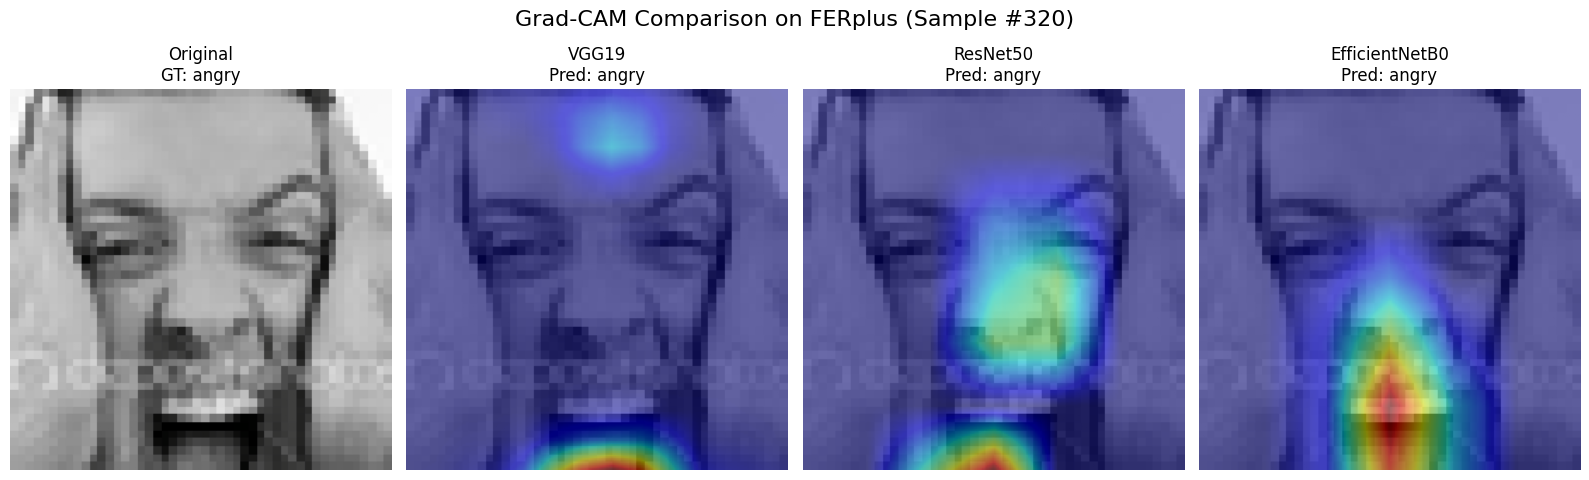

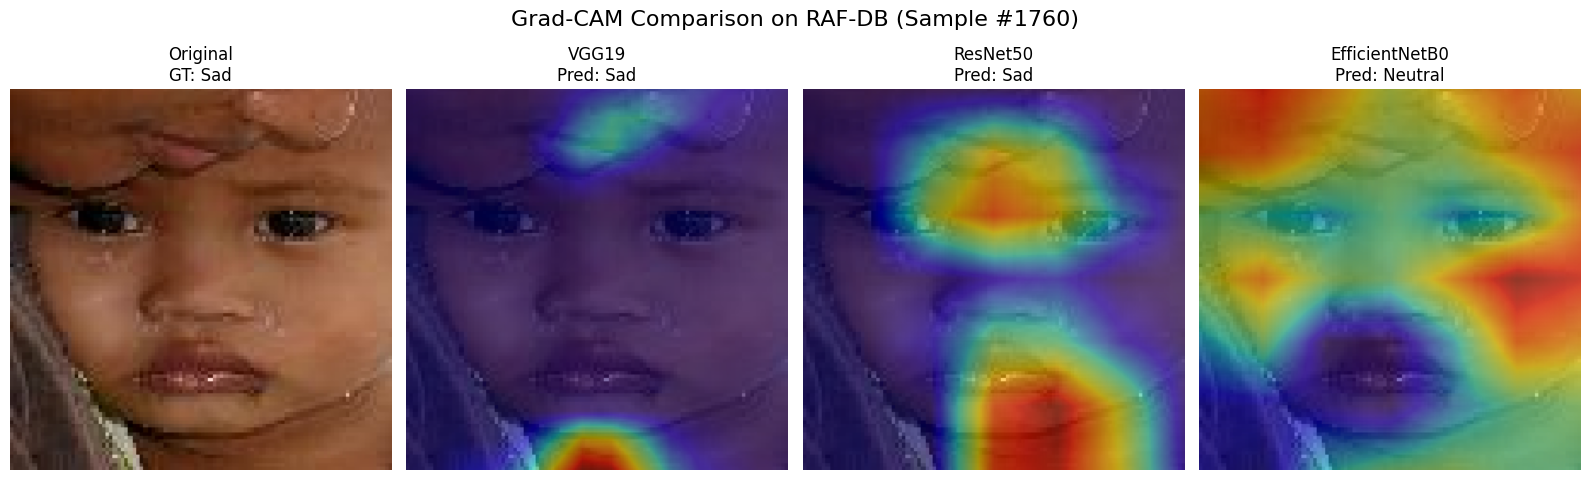

In [62]:
for dataset_name in datasets_info:
    if dataset_name == 'RAF-DB':
        class_names = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Anger', 'Neutral']
    else:
        class_names = list(test_gen.class_indices.keys())

    sample_index = {
        'FER2013': 90,
        'FERplus': 10,
        'RAF-DB': 55
    }

    cam_layer_name = {
    'VGG19': 'block5_conv4',         # VGG19 最後一層卷積層
    'ResNet50': 'conv5_block3_out',  # ResNet50 最後一個 block 的輸出層
    'EfficientNetB0': 'top_conv'     # EfficientNetB0 的最後一層卷積層
    }

    visualize_same_image_across_models(task_info, class_names, cam_layer_name, dataset_name, sample_index=sample_index[dataset_name])

## save/load task_info

In [16]:
import copy
import pickle
import os
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

def strip_unserializable(task_info):
    """
    Creates a new dictionary from task_info, excluding unserializable items.
    """
    clean_info = {}
    for model_name, model_data in task_info.items():
        clean_info[model_name] = {}
        for dataset_name, dataset_data in model_data.items():
            # Create a new dictionary for dataset data, copying only serializable items
            clean_dataset_data = {}
            for key, value in dataset_data.items():
                # Exclude 'model' and 'test_generator'
                if key not in ["model", "test_generator"]:
                    # For other items, attempt a deepcopy if necessary,
                    # though a shallow copy or direct assignment might suffice
                    # depending on the structure of other data.
                    # Here we assume other data is serializable.
                    clean_dataset_data[key] = copy.deepcopy(value) # Use deepcopy for embedded mutable objects

            clean_info[model_name][dataset_name] = clean_dataset_data
    return clean_info

# The rest of the code remains the same
clean_task_info = strip_unserializable(task_info)

with open(os.path.join(save_dir, "task_info.pkl"), 'wb') as f:
    pickle.dump(clean_task_info, f)

In [ ]:
import pickle

# 讀取 task_info
with open(os.path.join(save_dir, "task_info.pkl")) as f:
    task_info = pickle.load(f) # without model and dataloader

task_info = load_task_usages(task_info, models_info, datasets_info)